# BreakHis Image Classification with 🤗 Vision Transformers and `TensorFlow`

## Installation

In [1]:
# !pip install transformers datasets "tensorflow==2.6.0" tensorflow-addons --upgrade

## Setup & Configuration

In this step, we will define global configurations and parameters, which are used across the whole end-to-end fine-tuning process, e.g. `feature extractor` and `model` we will use. 

In this example we are going to fine-tune the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) a Vision Transformer (ViT) pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224.
There are also [large](https://huggingface.co/google/vit-large-patch16-224-in21k) and [huge](https://huggingface.co/google/vit-huge-patch14-224-in21k) flavors of original ViT.

In [2]:
results_dir_name = '400x_2023_05_10-21_50_58'

In [3]:
from datasets import load_dataset
import json
from keras.utils import to_categorical
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from transformers import create_optimizer, DefaultDataCollator, ViTImageProcessor, TFViTForImageClassification


2023-05-10 22:23:35.429460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 22:23:36.743285: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64::/home/miki/anaconda3/lib/:/home/miki/anaconda3/envs/tf/lib/
2023-05-10 22:23:36.743397: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64::/home/miki/ana

## Dataset & Pre-processing

- **Data Source:** https://www.kaggle.com/code/nasrulhakim86/breast-cancer-histopathology-images-classification/data
- The Breast Cancer Histopathological Image Classification (BreakHis) is composed of 9,109 microscopic images of breast tumor tissue collected from 82 patients.
- The images are collected using different magnifying factors (40X, 100X, 200X, and 400X). 
- To date, it contains 2,480 benign and 5,429 malignant samples (700X460 pixels, 3-channel RGB, 8-bit depth in each channel, PNG format).
- This database has been built in collaboration with the P&D Laboratory – Pathological Anatomy and Cytopathology, Parana, Brazil (http://www.prevencaoediagnose.com.br). 
- Each image filename stores information about the image itself: method of procedure biopsy, tumor class, tumor type, patient identification, and magnification factor. 
- For example, SOBBTA-14-4659-40-001.png is the image 1, at magnification factor 40X, of a benign tumor of type tubular adenoma, original from the slide 14-4659, which was collected by procedure SOB.

The `BreakHis` is not yet available as a dataset in the `datasets` library. To be able to create a `Dataset` instance we need to write a small little helper function, which will load our `Dataset` from the filesystem and create the instance to use later for training.

This notebook assumes that the dataset is available in directory tree next to this file and its directory name is `breakhis_400x`

In [4]:
cwd = Path().absolute()
output_path = cwd / 'results' / results_dir_name

output_path

PosixPath('/home/miki/Documents/studia/praca_dyplomowa/vcs/results/400x_2023_05_10-21_50_58')

#### Load models - just a demo

In [5]:
with open(output_path / 'best_model_info.json', 'r') as f:
    best_model_info = json.load(f)

best_model_info


{'idx': 0,
 'model_id': 'google/vit-base-patch16-224-in21k',
 'zoom': 400,
 'n_splits': 5,
 'num_train_epochs': 10,
 'train_batch_size': 3,
 'eval_batch_size': 3,
 'learning_rate': 3e-05,
 'weight_decay_rate': 0.01,
 'num_warmup_steps': 0,
 'num_train_steps': 3780}

In [6]:
input_path = cwd / f'breakhis_{best_model_info["zoom"]}x'

In [7]:
import pandas as pd

csv_files = [output_path / f'train_metrics_{idx}.csv' for idx in range(best_model_info["n_splits"])]
dataframes = [pd.read_csv(file) for file in csv_files]


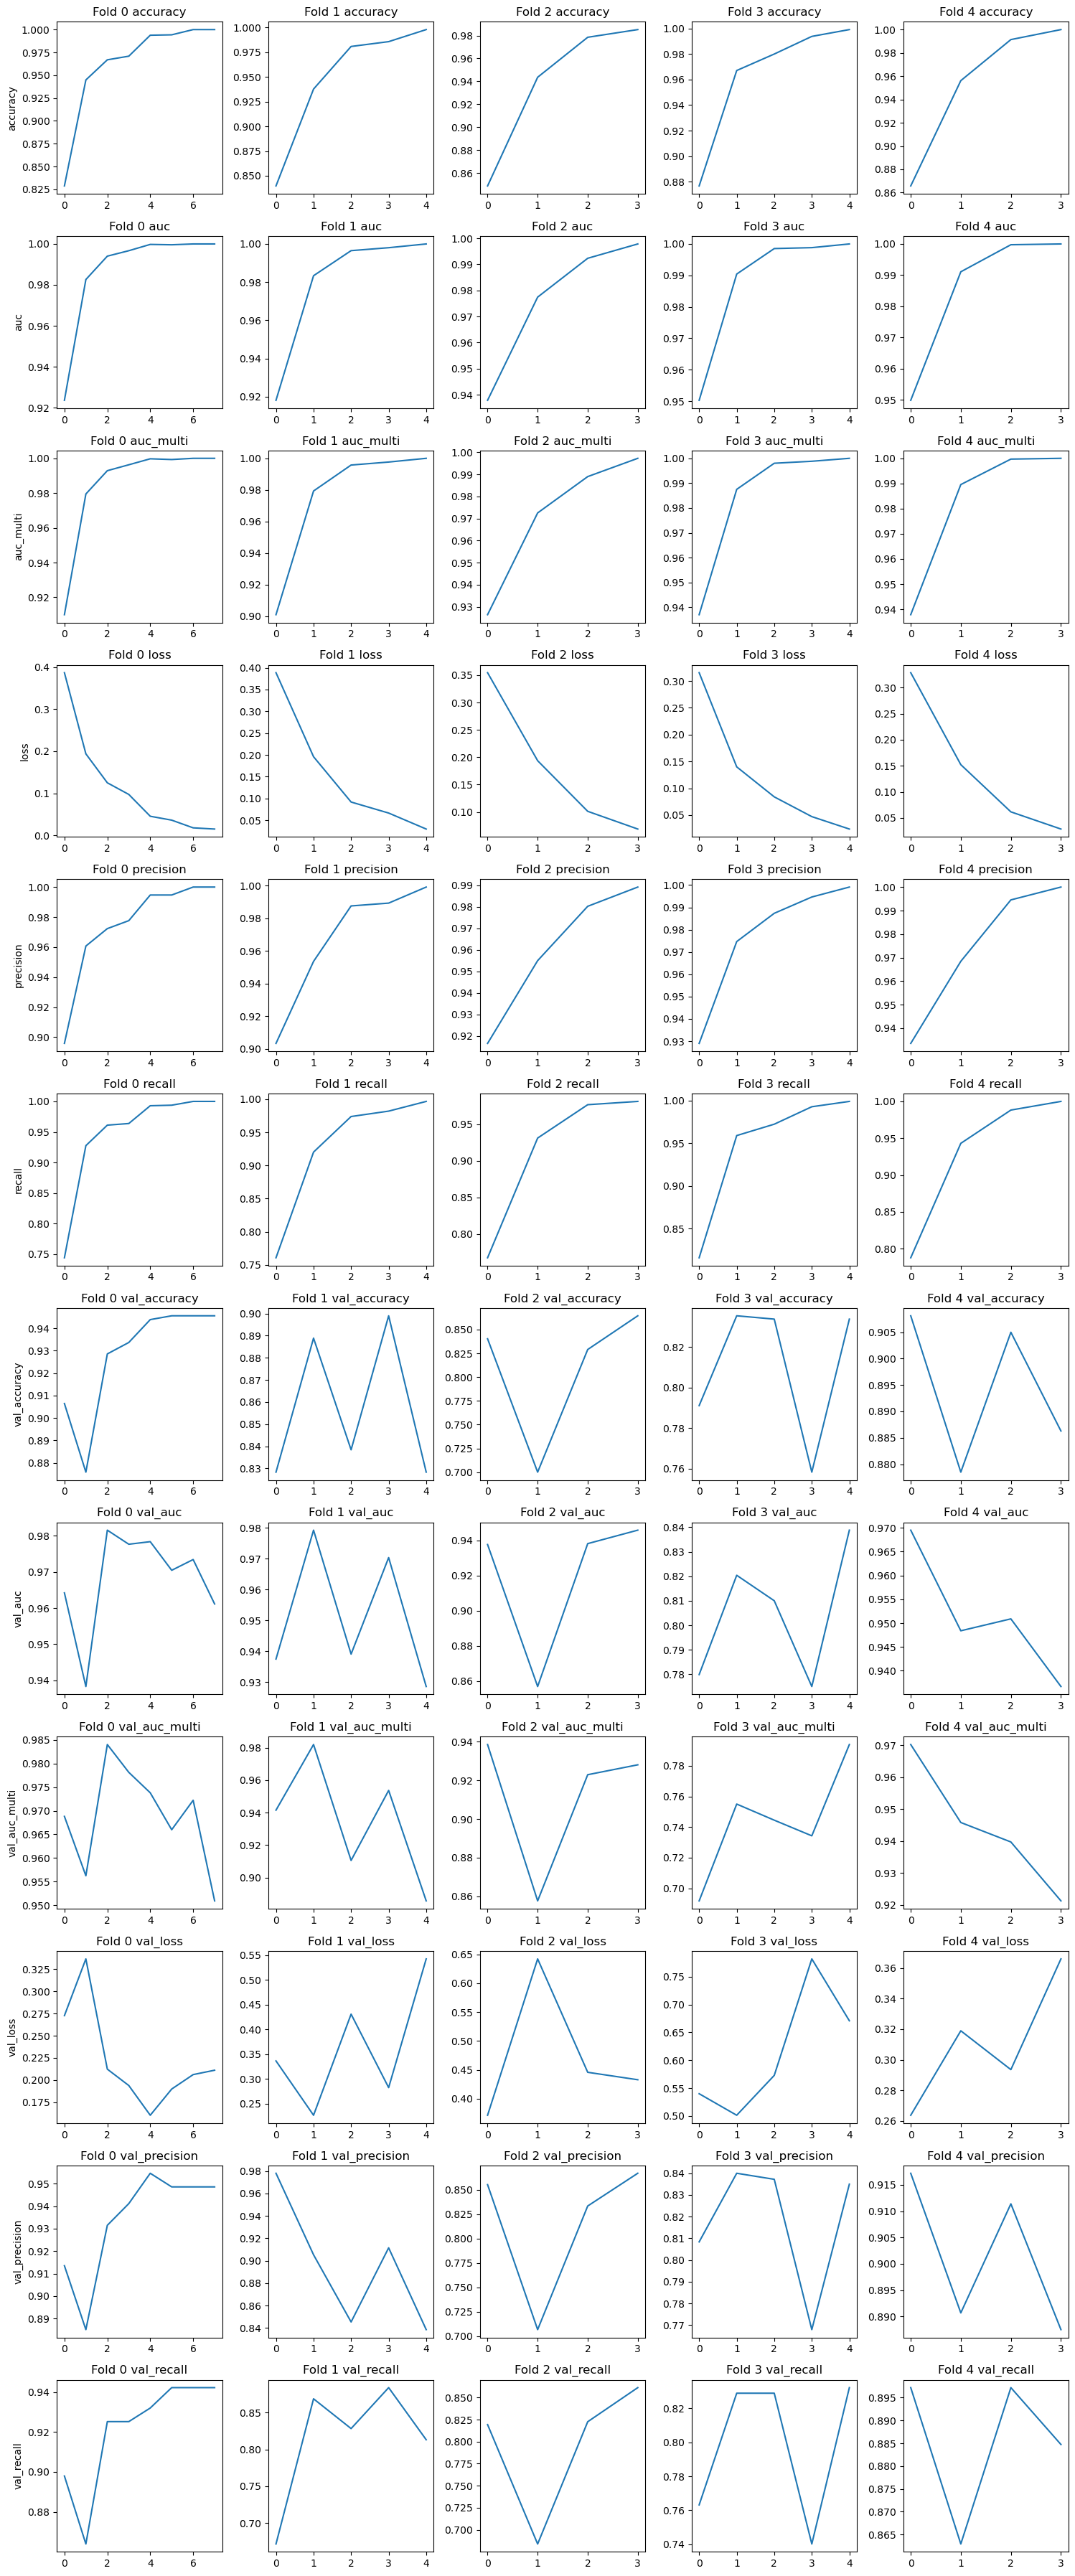

In [8]:
metrics = ['accuracy', 'auc', 'auc_multi', 'loss', 'precision', 'recall',
           'val_accuracy', 'val_auc', 'val_auc_multi', 'val_loss', 'val_precision', 'val_recall']
num_metrics = len(metrics)

fig, axes = plt.subplots(num_metrics, len(dataframes),
                         figsize=(15, num_metrics * 3))

for i, metric in enumerate(metrics):
    for j, df in enumerate(dataframes):
        axes[i][j].plot(df[metric])
        axes[i][j].set_title(f'Fold {j} {metric}')
        if j == 0:
            axes[i][j].set_ylabel(metric)

plt.tight_layout()
plt.savefig(output_path / 'train_metrics.png')
plt.show()


In [9]:
# last_layer = loaded_model.layers[-1]

# # Print details about the last layer
# print("Last layer details:")
# print("Type:", type(last_layer))
# print("Name:", last_layer.name)
# # print("Input shape:", last_layer.input_shape)
# # print("Output shape:", last_layer.output_shape)
# print("Activation function:", last_layer.activation.__name__)
# print("Number of parameters:", last_layer.count_params())

#### Final evaluation on test dataset

In [10]:
tf.debugging.disable_traceback_filtering()


image_processor = ViTImageProcessor.from_pretrained(best_model_info['model_id'])


def remove_extra_dim(example):
    example['pixel_values'] = np.squeeze(example['pixel_values'], axis=0)
    return example


def process_example(image):
    inputs = image_processor(image, return_tensors='tf')
    return inputs['pixel_values']


def process_dataset(example):
    example['pixel_values'] = process_example(
        Image.open(example['file_loc']).convert("RGB"))

    # example['pixel_values']=np.squeeze(example['pixel_values'], axis=0)
    example['label'] = to_categorical(example['label'], num_classes=2)
    return example


def load_test_data():
    test_csv = str(input_path / 'test.csv')
    dataset = load_dataset(
        'csv', data_files={'test': test_csv})

    dataset = dataset.map(process_dataset, with_indices=False, num_proc=1)

    print(f"Loaded test dataset: {len(dataset['test'])} samples")

    return dataset.map(remove_extra_dim)


test_dataset = load_test_data()

data_collator = DefaultDataCollator(return_tensors="tf")

test_dataset_tf = test_dataset['test'].to_tf_dataset(
    columns=['pixel_values'],
    label_cols=['label'],
    shuffle=False,
    batch_size=best_model_info['eval_batch_size'],
    collate_fn=data_collator)


Found cached dataset csv (/home/miki/.cache/huggingface/datasets/csv/default-b09a1f1158cc6dcb/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/miki/.cache/huggingface/datasets/csv/default-b09a1f1158cc6dcb/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-0f794f7cdb9541c7.arrow
Loading cached processed dataset at /home/miki/.cache/huggingface/datasets/csv/default-b09a1f1158cc6dcb/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-914d226e21077581.arrow
2023-05-10 22:23:47.866975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-10 22:23:47.870614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-10 22:23:47.870799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read

Loaded test dataset: 393 samples


e NUMA node, so returning NUMA node zero
2023-05-10 22:23:47.871744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-10 22:23:47.871873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-10 22:23:48.300970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-10 22:23:48.301142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-10 22:23:48.301274:

In [11]:
best_model = TFViTForImageClassification.from_pretrained(output_path / 'best_model')

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

metrics = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.AUC(name='auc', from_logits=True),
    tf.keras.metrics.AUC(name='auc_multi', from_logits=True, num_labels=2, multi_label=True),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.Precision(name='precision'),
    tfa.metrics.F1Score(name='f1_score', num_classes=2, threshold=0.5),
]

optimizer, _ = create_optimizer(
    init_lr=best_model_info['learning_rate'],
    num_train_steps=best_model_info['num_train_steps'],
    weight_decay_rate=best_model_info['weight_decay_rate'],
    num_warmup_steps=best_model_info['num_warmup_steps'],
)
best_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

results = best_model.evaluate(test_dataset_tf)

2023-05-10 22:23:49.767386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-05-10 22:23:50.445157: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-10 22:23:50.446013: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-10 22:23:50.446034: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-05-10 22:23:50.447075: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-10 22:23:50.447147: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-05-10 22:23:51.000835:

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
131/131 [==============================] - 10s 48ms/step - loss: 1.4278 - accuracy: 0.8295 - auc: 0.8095 - auc_multi: 0.7820 - recall: 0.8270 - precision: 0.8291 - f1_score: 0.7929


In [12]:
print("Test dataset evaluation results:")
test_metrics = {}
for metric, value in zip(best_model.metrics_names, results):
    print(metric, value)
    if isinstance(value, np.ndarray):
        value = list(value)
        value = [str(v) for v in value]
    else:
        value = str(value)
    test_metrics[metric] = value

with open(output_path / 'test_metrics.json', 'w') as test_metrics_json:
    json.dump(test_metrics, test_metrics_json, indent = 4)

Test dataset evaluation results:
loss 1.4278219938278198
accuracy 0.8295165300369263
auc 0.8094645142555237
auc_multi 0.7819727659225464
recall 0.8269720077514648
precision 0.829081654548645
f1_score [0.70689654 0.8788426 ]
{'loss': '1.4278219938278198', 'accuracy': '0.8295165300369263', 'auc': '0.8094645142555237', 'auc_multi': '0.7819727659225464', 'recall': '0.8269720077514648', 'precision': '0.829081654548645', 'f1_score': ['0.70689654', '0.8788426']}


#### Let's take a look at the details of the predictions

In [13]:
preds = best_model.predict(test_dataset_tf)
probabilities = tf.nn.softmax(preds.logits, axis=-1)


131/131 [==============================] - 8s 47ms/step


In [14]:
preds

TFSequenceClassifierOutput(loss=None, logits=array([[-4.379507  ,  4.3961    ],
       [-4.340319  ,  4.3636613 ],
       [-4.3842187 ,  4.407529  ],
       [-4.361207  ,  4.393527  ],
       [-4.3522058 ,  4.3386593 ],
       [-4.353655  ,  4.380118  ],
       [-4.374678  ,  4.392955  ],
       [-4.3552966 ,  4.384628  ],
       [-4.3686595 ,  4.408085  ],
       [-4.2870502 ,  4.3114066 ],
       [-4.365086  ,  4.404194  ],
       [-4.3286514 ,  4.356859  ],
       [-4.3547177 ,  4.395826  ],
       [-4.299199  ,  4.3425937 ],
       [-4.3579206 ,  4.383593  ],
       [-4.355999  ,  4.3784266 ],
       [-4.248547  ,  4.281865  ],
       [-4.3645344 ,  4.4127884 ],
       [-4.2038064 ,  4.2792516 ],
       [-4.3928127 ,  4.387216  ],
       [-4.385149  ,  4.4034863 ],
       [-4.3240886 ,  4.3683705 ],
       [-4.3444777 ,  4.3775344 ],
       [-4.3841257 ,  4.4114285 ],
       [-4.3462505 ,  4.3629932 ],
       [-4.336014  ,  4.3686137 ],
       [-4.358782  ,  4.3831053 ],
       [-4

In [15]:
labels_pred = np.argmax(probabilities, axis=-1)
labels_pred


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [16]:
np.array(test_dataset['test']['label'])


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [17]:
# Extract file locations and real labels from the test dataset
file_locs = [example['file_loc'] for example in test_dataset['test']]
labels = [np.argmax(example['label']) for example in test_dataset['test']]

# Create a DataFrame
results_df = pd.DataFrame(
    {'file_loc': file_locs, 'label': labels, 'label_pred': labels_pred})

# Save the DataFrame as a CSV file
results_df.to_csv(output_path / f'test_results.csv', index=False)


#### Calculate model's accuracy manually - just in case

In [18]:
correct_predictions = np.sum(results_df['label'] == results_df['label_pred'])

# Calculate the total number of predictions
total_predictions = len(results_df)

# Calculate the accuracy
accuracy = correct_predictions / total_predictions

print("Manual accuracy calculation:", accuracy)


Manual accuracy calculation: 0.8295165394402035
